In [52]:
import numpy as np
import random
import time

In [53]:
def load_distance_matrix(file_path):
    with open(file_path, 'r') as f:
        matrix = [list(map(float, line.split())) for line in f]
    return matrix

In [54]:
def get_distance(start, end, distance_matrix):
    size = len(distance_matrix)
    return distance_matrix[start % size][end % size]

def calculate_total_distance(route, distance_matrix):
    return sum(get_distance(route[i],route[i+1], distance_matrix) for i in range(len(route) - 1))
    # return sum(distance_matrix[route[i]][route[i+1]] for i in range(len(route) - 1))

In [55]:
def two_opt(route, distance_matrix):
    best = route.copy()
    improved = True
    while improved:
        improved = False
        for i in range(1, len(best) - 1):
            for j in range(i + 1, len(best)):
                if j - i == 1:
                    continue  # Skip adjacent edges
                new_route = best[:]
                new_route[i:j] = reversed(best[i:j])  # Perform 2-opt swap
                if calculate_total_distance(new_route, distance_matrix) < calculate_total_distance(best, distance_matrix):
                    best = new_route
                    improved = True
    return best

In [56]:
def create_deterministic_individual(cluster_points, method='reverse'):
    if method == 'reverse':
        individual = cluster_points[:1] + cluster_points[1:][::-1]
    elif method == 'rotate':
        individual = cluster_points[:]
        individual = [individual[0]] + individual[1:][1:] + [individual[1]]
    return individual

In [57]:
def crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted([1, size // 2])
    child = [-1] * size
    child[start:end] = parent1[start:end]
    for i in range(size):
        if parent2[i] not in child and -1 in child:
            index = child.index(-1)
            child[index] = parent2[i]
    return child

In [58]:
def mutate(individual):
    idx1, idx2 = random.sample(range(1, len(individual)), 2)
    individual[idx1], idx2 = individual[idx2], individual[idx1]

In [59]:
def validate_route(route):
    return all(x >=0 for x in route)

In [60]:
def hybrid_ga_2opt(distance_matrix, cluster_points, generations=100, seed=42):
    # random.seed(seed)
    np.random.seed(seed)

    population_size = 10
    population = [create_deterministic_individual(cluster_points) for _ in range(population_size)]
    best_solution = None
    best_distance = float('inf')
    history = []

   
    start_time = time.process_time()  

    for generation in range(generations):
        temp = 0
        for individual in population:
            individual = two_opt(individual, distance_matrix)
            distance = calculate_total_distance(individual, distance_matrix)
            # temp = distance
            # history.append(distance)
            if distance < best_distance:
                best_solution, best_distance = individual, distance
        history.append(best_distance)

    #Crossover & Mutation
        next_generation = []
        for i in range(population_size):
            parent1 = population[i]
            parent2 = population[(i + 1) % len(population)]
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            mutate(child1)
            mutate(child2)
            if validate_route(child1):
                next_generation.append(child1)
            if validate_route(child2):
                next_generation.append(child2)
        while len(next_generation) < population_size:
            new_individual = create_deterministic_individual(cluster_points)
            if validate_route(new_individual):
                next_generation.append(new_individual)
                
        population = next_generation[:population_size]

    runtime = time.process_time() - start_time  

    return best_solution, round(best_distance, 1), runtime, history


In [61]:
def optimize_clusters(file_path, clusters, seed=42):
    distance_matrix = load_distance_matrix(file_path)
    results = {}

    for cluster_id, cluster_points in clusters.items():
        # print(f"Processing Cluster {cluster_id}...")
        best_route, shortest_distance, runtime, history = hybrid_ga_2opt(distance_matrix, cluster_points, generations=100, seed=seed)
        results[f"Cluster {cluster_id}"] = {
            "Route": best_route,
            "Shortest Distance": shortest_distance,
            "Runtime": round(runtime, 10),  
            "History": history
        }
    
    return results

In [62]:
# random.seed(42)
np.random.seed(42)

file_path = 'dataset.txt'  
clusters = {
    1: [0, 2, 13, 9, 14, 10, 11, 19],
    2: [0, 32, 34, 40, 60, 63, 67, 68, 69],
    3: [0, 20, 29, 37, 41, 44, 45, 46, 47, 49],
    4: [0, 16, 21, 22, 23, 24, 25, 26, 28, 30],
    5: [0, 1, 52, 53, 54, 55, 56, 57, 58, 59, 65],
    6: [0, 31, 33, 35, 36, 39, 42, 43, 48, 50, 51],
    7: [0, 3, 4, 5, 6, 7, 8, 12, 61],
    8: [0, 15, 17, 18, 27, 38, 62, 64, 66, 70]
}

In [63]:
results = optimize_clusters(file_path=file_path, clusters=clusters)

total_distance = 0
total_runtimes = 0
for cluster_name, cluster_info in results.items():
    print(f"{cluster_name}:")
    print(f"  Route: {cluster_info['Route']}")
    print(f"  Shortest Distance: {cluster_info['Shortest Distance']}")
    print(f"  Runtime: {cluster_info['Runtime']} seconds\n")
   
    total_distance += cluster_info["Shortest Distance"]
    total_runtimes += cluster_info["Runtime"]
print("\n\n")
print(f"  Total Shortest Distance: {round(total_distance, 1)}")
print(f"  Total Fastest Runtimes: {round(total_runtimes, 1)}")

Cluster 1:
  Route: [0, 19, 14, 9, 11, 13, 11, 13]
  Shortest Distance: 18.7
  Runtime: 0.046875 seconds

Cluster 2:
  Route: [0, 67, 68, 63, 69, 63, 32, 40, 34]
  Shortest Distance: 14.7
  Runtime: 0.078125 seconds

Cluster 3:
  Route: [0, 49, 47, 20, 47, 45, 37, 46, 41, 44]
  Shortest Distance: 24.9
  Runtime: 0.046875 seconds

Cluster 4:
  Route: [0, 26, 23, 25, 23, 21, 24, 21, 22, 30]
  Shortest Distance: 24.6
  Runtime: 0.109375 seconds

Cluster 5:
  Route: [0, 57, 54, 57, 58, 55, 56, 59, 54, 57, 53]
  Shortest Distance: 17.8
  Runtime: 0.125 seconds

Cluster 6:
  Route: [0, 33, 48, 43, 42, 39, 50, 36, 35, 48, 35]
  Shortest Distance: 24.4
  Runtime: 0.140625 seconds

Cluster 7:
  Route: [0, 61, 3, 12, 8, 12, 8, 5, 7]
  Shortest Distance: 23.6
  Runtime: 0.046875 seconds

Cluster 8:
  Route: [0, 38, 64, 66, 70, 62, 15, 18, 15, 18]
  Shortest Distance: 15.6
  Runtime: 0.03125 seconds




  Total Shortest Distance: 164.3
  Total Fastest Runtimes: 0.6


convergence graph => cluster 5

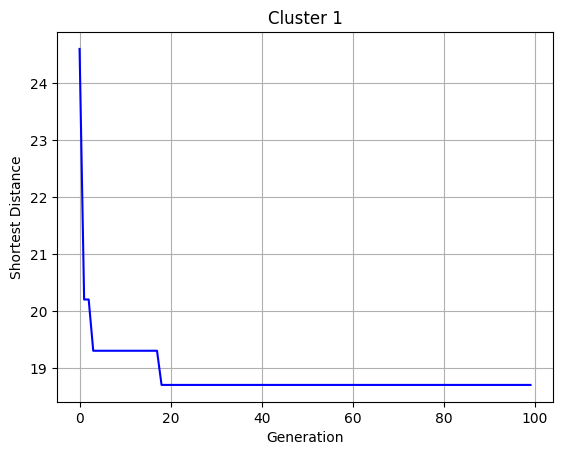

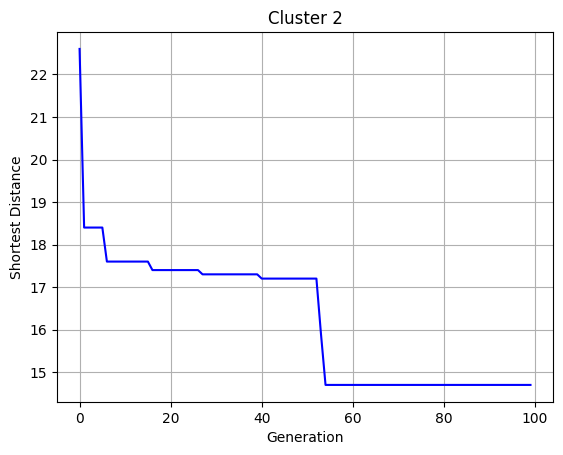

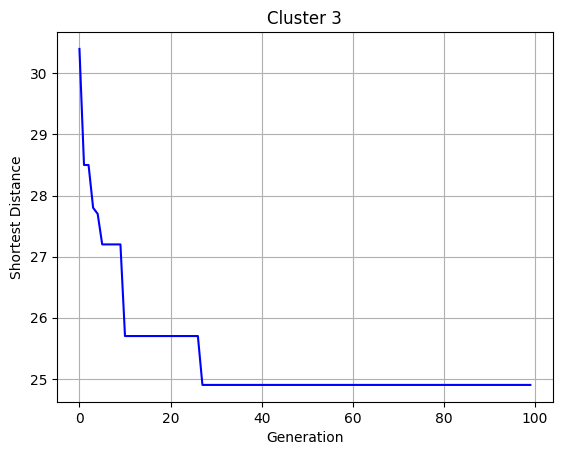

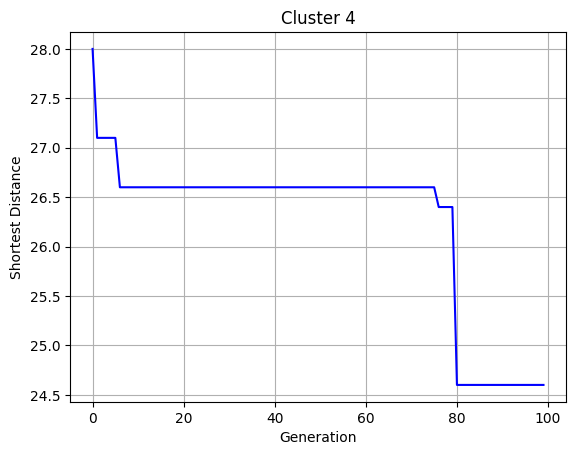

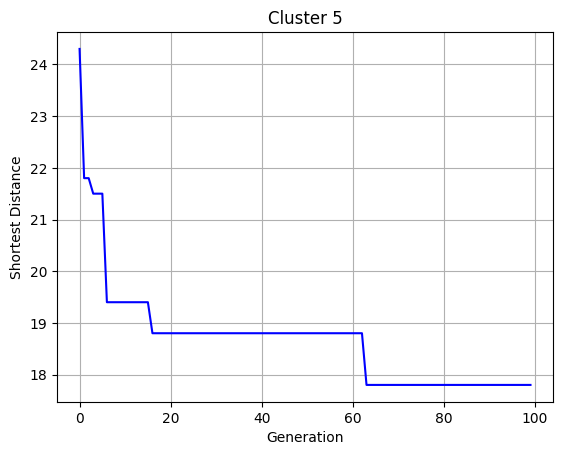

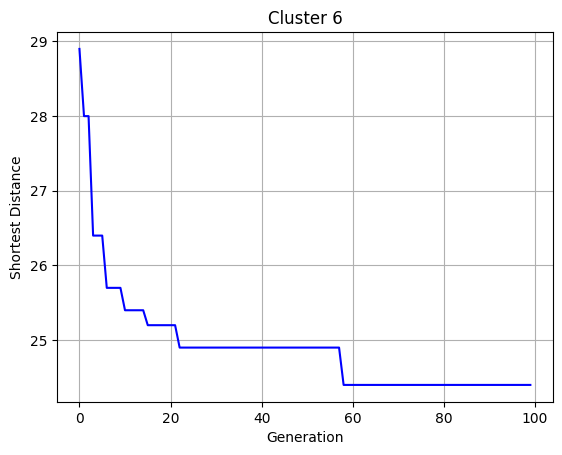

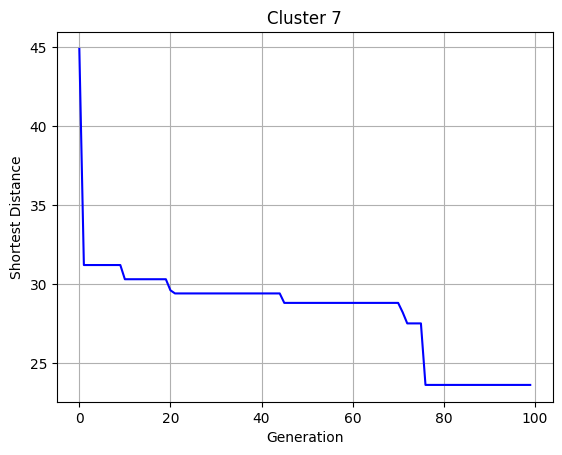

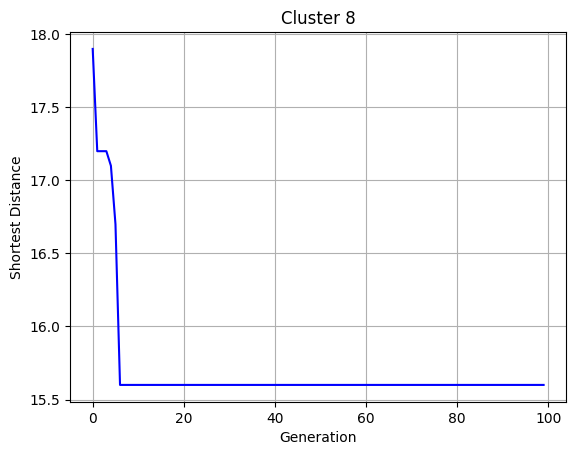

In [64]:
import matplotlib.pyplot as plt


for cluster_name, cluster_info in results.items():
    y = results[cluster_name]['History']
    x = list(map(lambda x: x, range(0, 100)))

    plt.title(cluster_name)
    plt.plot(x, y, marker='', color='b')
    plt.xlabel('Generation')
    plt.ylabel('Shortest Distance')
    plt.grid(True)
    plt.show()


## Visualization

In [65]:
import matplotlib.pyplot as plt
def cumulative_distances_visualization(route, cumulative_distances, shortest_distance, xLabel, yLabel, tittle):
    # Plotting the route with cumulative distance
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(route)), cumulative_distances, marker='o', linestyle='-', color='b')

    plt.title(tittle)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.xticks(range(len(route)), route)
    plt.grid(True)

    # Annotate the shortest distance
    plt.axhline(y=shortest_distance, color='r', linestyle='--', label=f'Shortest Distance: {shortest_distance}')
    plt.legend()

    plt.show()

In [66]:
distance_matrix = load_distance_matrix(file_path)

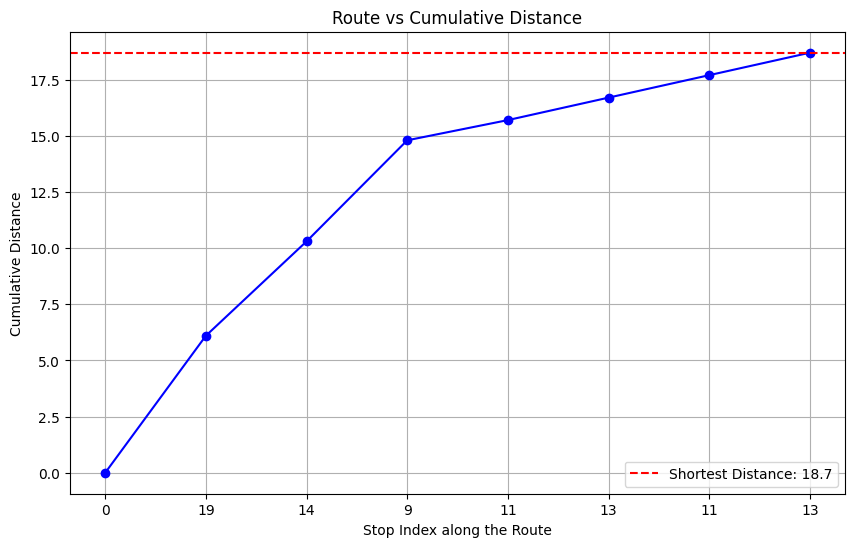

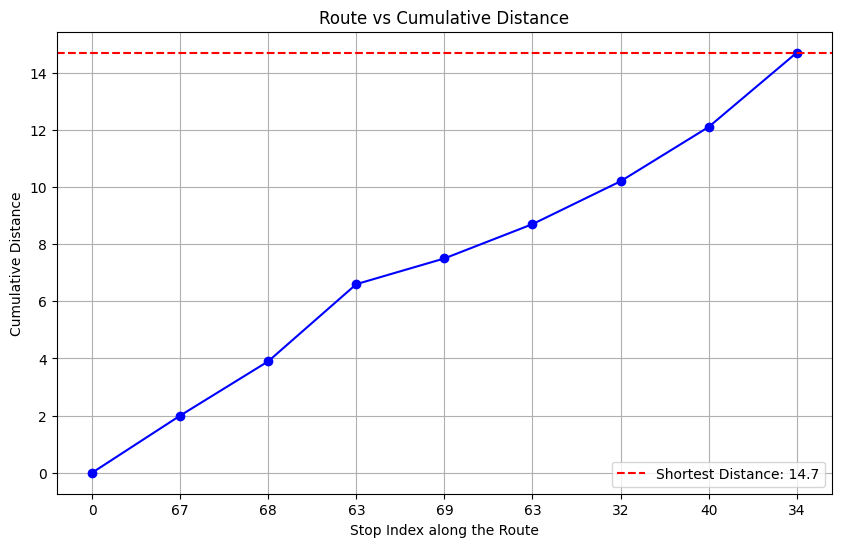

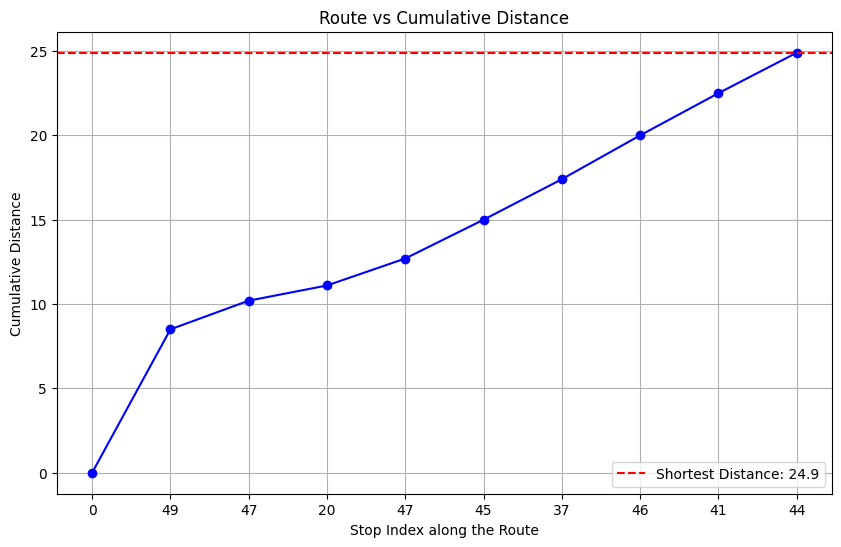

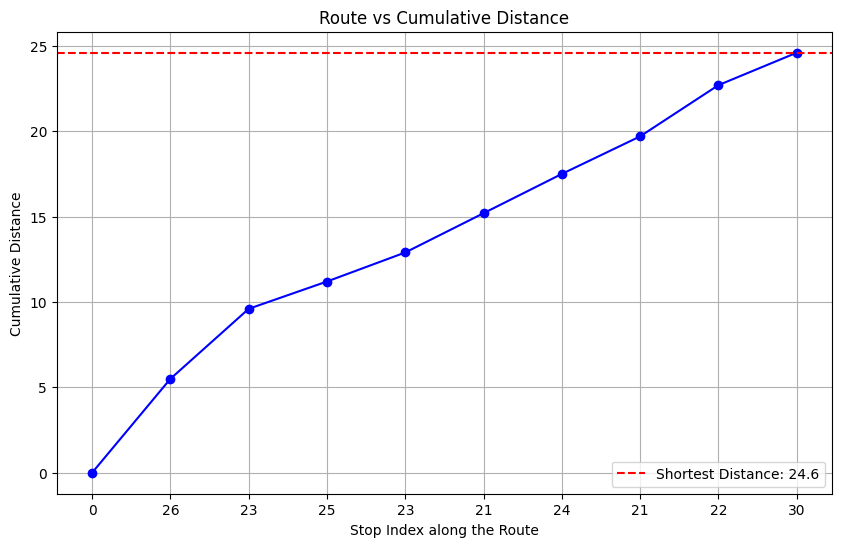

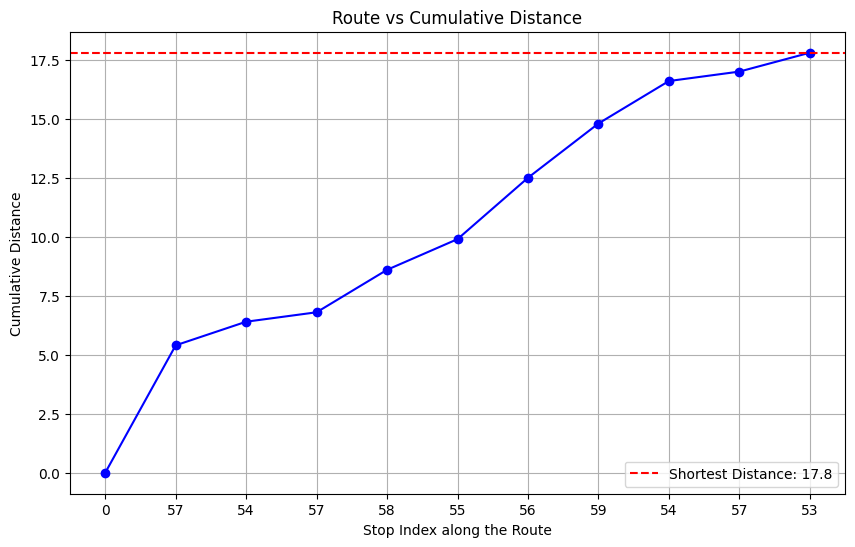

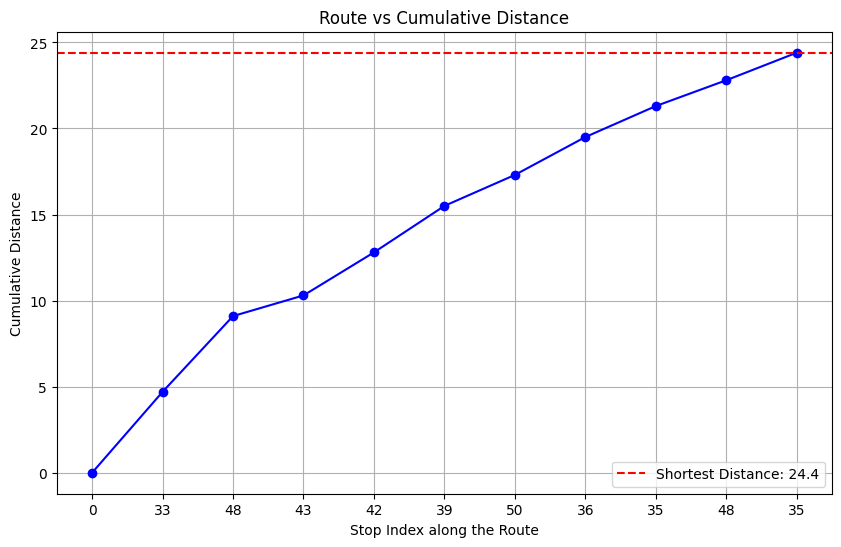

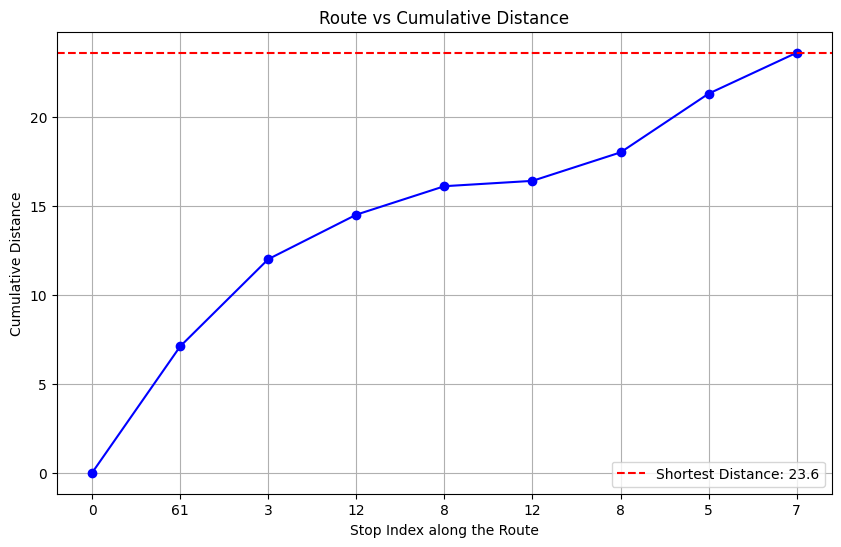

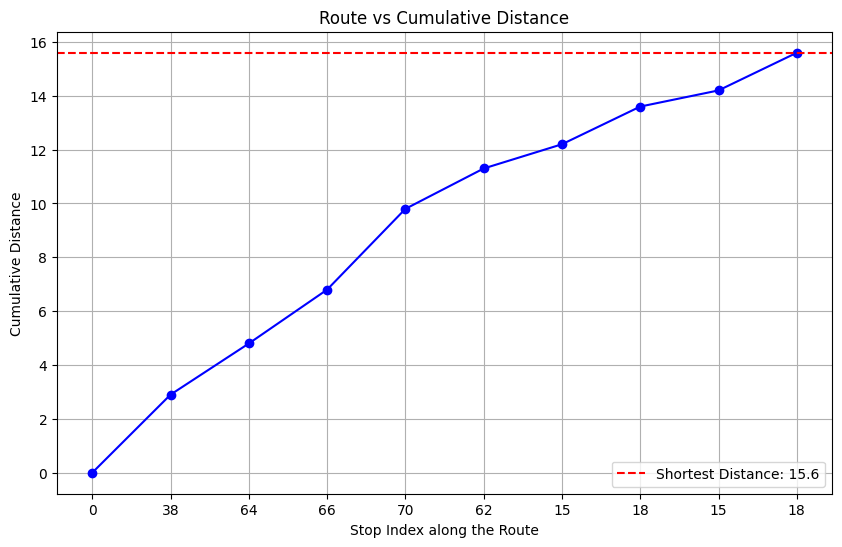

In [67]:
import numpy as np

for name, cluster in results.items():
    route = cluster['Route']
    shortest_distance = cluster["Shortest Distance"]
    distance_ar = []
    individual_distance = []

    for i in range(len(route)-1):
        if i != len(route)-1:
            individual_distance.append(get_distance(route[i], route[i+1], distance_matrix))
        else:
            individual_distance.append(get_distance(route[i], route[0], distance_matrix))

    temp = 0
    idx = 0
    for i in individual_distance:
        distance_ar.append(i + temp)
        temp = distance_ar[idx]
        idx += 1
    distance_ar.insert(0, 0)
    individual_distance.insert(0, 0)
    # print(f'route : {route}')
    # print(f'shortest_distance : {shortest_distance}')
    # print('distance arr : ',distance_ar)
    # print(f'sum indiv : {sum(individual_distance)}\n\n')
    cumulative_distances_visualization(route, distance_ar, shortest_distance, 'Stop Index along the Route', 'Cumulative Distance', 'Route vs Cumulative Distance')
    # cumulative_distances_visualization(route, individual_distance, shortest_distance, 'Stop Index along the Route', 'node distance', 'Rotue vs node distance')
    print('\n\n\n\n')
    # cumulative_distances_visualization(individual_distance, distance_ar, shortest_distance)



